# Predicting fuel consumption

In [60]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras


print(tf.__version__)

2.12.0


Escolha uma base de dados pública que represente um problema supervisionado de classificação ou de regressão e utilizando uma rede neural MLP de uma camada oculta:

1. escreva uma rotina que carrega a base de dados e realiza o treinamento da MLP com validação cruzada k-fold (utilize bibliotecas de aprendizado de máquina e k=5).
2. varie o número de neurônios da camada oculta buscando o melhor resultado de treinamento utilizando o algoritmo Backpropagation:
  * realize 5 inicializações do treinamento e exiba os resultados considerando o valor médio e o desvio padrão;
  * a depender do problema escolhido, o parâmetro de avaliação do desempenho pode mudar, justifique a escolha do parâmetro utilizado;
  * analise as curvas de treinamento -> em algum caso houve overfitting? Justifique.
3. com o modelo definido no item 2 (após a escolha do número de neurônios da camada oculta), refaça o treinamento modificando parâmetros do algoritmo de treinamento como: tamanho da batelada e taxa de aprendizagem.
4. com o modelo definido no item 2 (após a escolha do número de neurônios da camada oculta), refaça o treinamento modificando o algoritmo de treinamento para Levemberg-Marquardt e R-PROP.

In [61]:
# from ucimlrepo import fetch_ucirepo

# # fetch dataset
# auto_mpg = fetch_ucirepo(id=9)

# # data (as pandas dataframes)
# X = auto_mpg.data.features
# y = auto_mpg.data.targets

# # metadata
# print(auto_mpg.metadata)

# # variable information
# print(auto_mpg.variables)


## Dataset

### Getting data

In [62]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\darth\\.keras\\datasets\\auto-mpg.data'

In [63]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

full_dataset = raw_dataset.copy()
full_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


### Cleaning data

In [64]:
full_dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [65]:
full_dataset = full_dataset.dropna()

In [66]:
origin = full_dataset.pop('Origin')
full_dataset['USA'] = (origin == 1)*1.0
full_dataset['Europe'] = (origin == 2)*1.0
full_dataset['Japan'] = (origin == 3)*1.0
full_dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


Analyzing distribution of data.

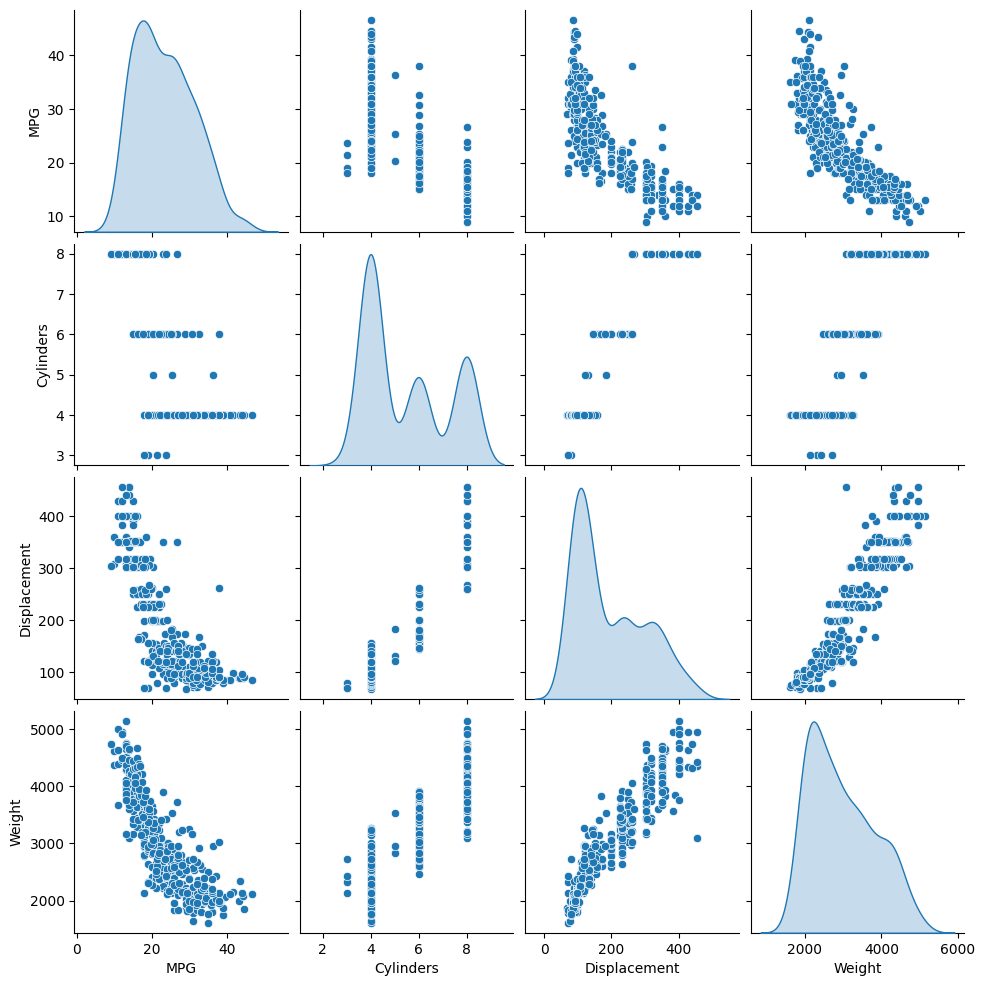

In [67]:
sns.pairplot(full_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

### Separating data

In [68]:
train_dataset = full_dataset.sample(frac=0.90, random_state=42)
test_dataset = full_dataset.drop(train_dataset.index)
train_dataset.reset_index(drop=True, inplace=True)
test_dataset.reset_index(drop=True, inplace=True)

X = train_dataset
y = X.pop('MPG')

X_test = test_dataset
y_test = X_test.pop('MPG')

print(len(train_dataset))
print(len(test_dataset))

353
39


In [69]:
train_dataset.reset_index()

,index,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,0,4,96.0,69.0,2189.0,18.0,72,0.0,1.0,0.0
1,1,4,121.0,115.0,2795.0,15.7,78,0.0,1.0,0.0
2,2,4,91.0,60.0,1800.0,16.4,78,0.0,0.0,1.0
3,3,4,91.0,70.0,1955.0,20.5,71,1.0,0.0,0.0
4,4,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
348,348,8,302.0,140.0,4141.0,14.0,74,1.0,0.0,0.0
349,349,4,151.0,90.0,2556.0,13.2,79,1.0,0.0,0.0
350,350,4,107.0,75.0,2205.0,14.5,82,0.0,0.0,1.0
351,351,4,108.0,75.0,2265.0,15.2,80,0.0,0.0,1.0


In [70]:
stats = X.describe()
stats = stats.transpose()
stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,353.0,5.509915,1.724008,3.0,4.0,4.0,8.0,8.0
Displacement,353.0,196.862606,106.026028,68.0,105.0,151.0,302.0,455.0
Horsepower,353.0,106.031161,39.321976,46.0,76.0,95.0,130.0,230.0
Weight,353.0,2997.790368,857.112834,1613.0,2230.0,2830.0,3632.0,5140.0
Acceleration,353.0,15.445326,2.753332,8.0,13.5,15.5,17.0,24.8
Model Year,353.0,75.963173,3.687556,70.0,73.0,76.0,79.0,82.0
USA,353.0,0.623229,0.485264,0.0,0.0,1.0,1.0,1.0
Europe,353.0,0.169972,0.376141,0.0,0.0,0.0,0.0,1.0
Japan,353.0,0.206799,0.405585,0.0,0.0,0.0,0.0,1.0


### Normalization

In [71]:
norm = MinMaxScaler().fit(X)

X = pd.DataFrame(norm.transform(X), columns=X.columns)
X_test = pd.DataFrame(norm.transform(X_test), columns=X_test.columns)

In [72]:
def norm(x):
  stats = x.describe()
  stats = stats.transpose
  mean = stats['mean']
  std = stats['std']

  return (x - mean) / std

# normed_train_data = norm(dataset)

## Model

In [147]:
def r2_metric(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

In [148]:
def get_model(neurons=10, input_shape=None):
    model = keras.models.Sequential([
        keras.layers.Input(shape=input_shape),
        keras.layers.Dense(neurons, activation='relu'),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer='Adam',
                  loss="mse",
                  metrics=['mae', r2_metric])
    return model

## Cross validation KFold

In [149]:
def make_dataset(X_data, y_data, n_splits):
    def gen():
        for train_index, test_index in KFold(n_splits).split(X_data):
            # Use `.iloc` se X_data ou y_data forem pandas DataFrame/Series
            X_train, X_test = X_data.iloc[train_index], X_data.iloc[test_index]
            y_train, y_test = y_data.iloc[train_index], y_data.iloc[test_index]
            yield X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy()

    return tf.data.Dataset.from_generator(gen, (tf.float64, tf.float64, tf.float64, tf.float64))

dataset = make_dataset(X, y, 5)
dataset

<_FlatMapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None), TensorSpec(shape=<unknown>, dtype=tf.float64, name=None))>

In [150]:
type(dataset)

tensorflow.python.data.ops.flat_map_op._FlatMapDataset

In [151]:
for fold, (X_train, y_train, X_val, y_val) in enumerate(dataset):
    print(f"Fold {fold + 1}:")
    print(f"  X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"  X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
    print()

Fold 1:
  X_train shape: (282, 9), y_train shape: (282,)
  X_val shape: (71, 9), y_val shape: (71,)

Fold 2:
  X_train shape: (282, 9), y_train shape: (282,)
  X_val shape: (71, 9), y_val shape: (71,)

Fold 3:
  X_train shape: (282, 9), y_train shape: (282,)
  X_val shape: (71, 9), y_val shape: (71,)

Fold 4:
  X_train shape: (283, 9), y_train shape: (283,)
  X_val shape: (70, 9), y_val shape: (70,)

Fold 5:
  X_train shape: (283, 9), y_train shape: (283,)
  X_val shape: (70, 9), y_val shape: (70,)



## Training

In [152]:
def train_kfold(dataset, neurons=5, epochs=100):
    models = []
    models_hist = {}
    final_metrics = {}

    for fold, (X_train, y_train, X_val, y_val) in enumerate(dataset):
        input_shape = X_train.shape[1:]  # Exclude the batch size

        model = get_model(input_shape=input_shape, neurons=5)
        print(f"Training fold number {fold}.")
        hist = model.fit(
            x=X_train, y=y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            verbose=0
        )

        # Saving model, history, and metrics
        models.append(model)
        models_hist[f'model_{fold}'] = hist
        
        for metric, values in hist.history.items():
            if metric not in final_metrics:
                final_metrics[metric] = []
            final_metrics[metric].append(values[-1])

    return models, models_hist, final_metrics

# models, models_hist, final_metrics = train_kfold(dataset)

In [153]:
# print("We will visualize:", list(models_hist['model_0'].history.keys()))

Plotting all the metrics

In [154]:
def plot_metrics(history_dict):
    # Separating training and validation metrics
    metrics = [key for key in history_dict.keys() if not key.startswith("val_")]
    val_metrics = ["val_" + metric for metric in metrics]
    
    num_metrics = len(metrics)
    fig, axs = plt.subplots(1, num_metrics, figsize=(4 * num_metrics, 3))

    if num_metrics == 1:
        axs = [axs]

    for i, metric in enumerate(metrics):
        sns.lineplot(data=history_dict[metric], label='Training ' + metric, ax=axs[i])
        sns.lineplot(data=history_dict[val_metrics[i]], label='Validation ' + metric, ax=axs[i])

        # Personalize each subplot
        axs[i].set_title(f"{metric.capitalize()} Over Epochs")
        axs[i].set_xlabel("Epoch")
        axs[i].set_ylabel(metric.capitalize())
        axs[i].legend()

    plt.tight_layout()
    plt.show()


# for history in models_hist:
#     history_dict = models_hist[history].history
#     plot_metrics(history_dict)

In [155]:
# print("Final Metrics (Mean ± Std):")
# for metric, values in final_metrics.items():
#     mean = np.mean(values)
#     std = np.std(values)
#     print(f". {metric}: {mean:.4f} ± {std:.4f}")

### Training with diferrent neurons

In [156]:
neurons_choices = [5, 10, 15, 25, 50]

Training fold number 0.
Training fold number 1.
Training fold number 2.
Training fold number 3.
Training fold number 4.


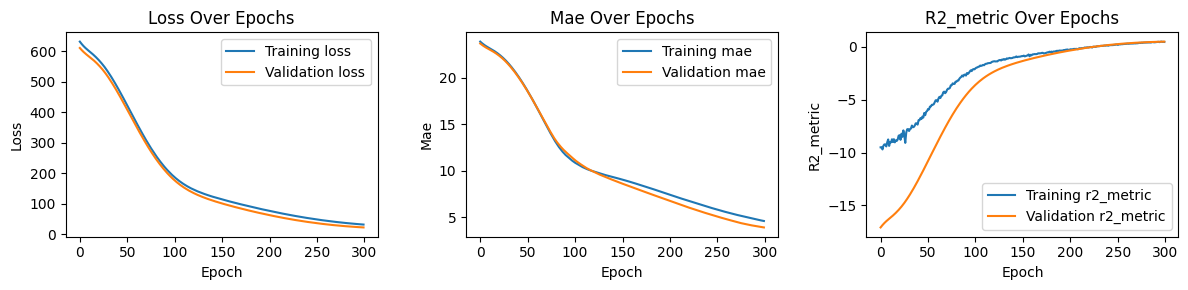

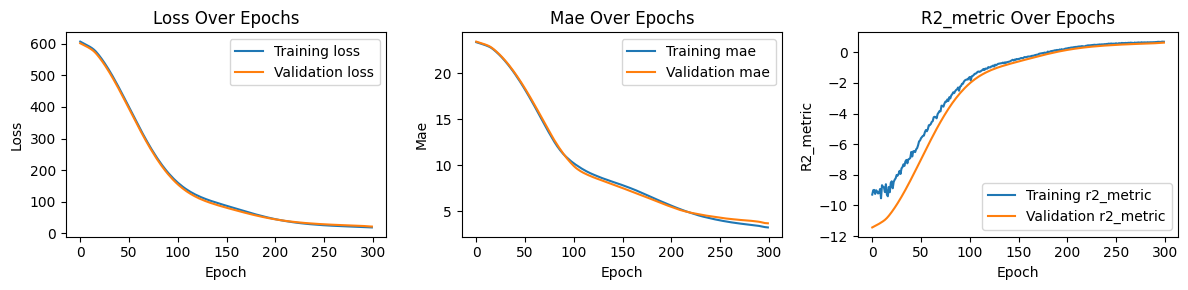

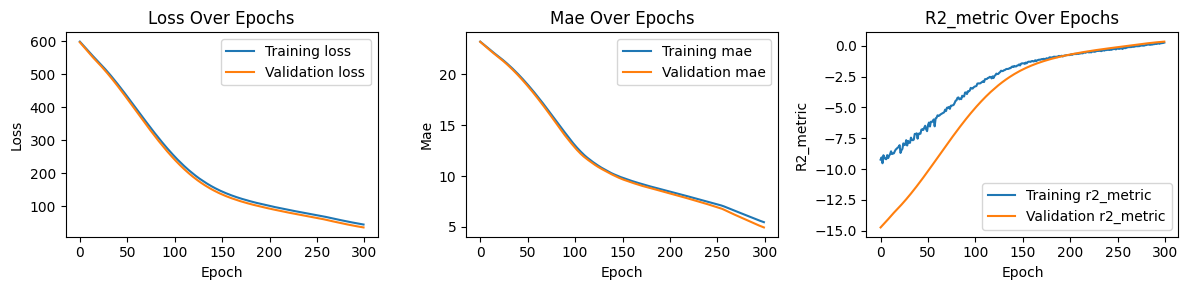

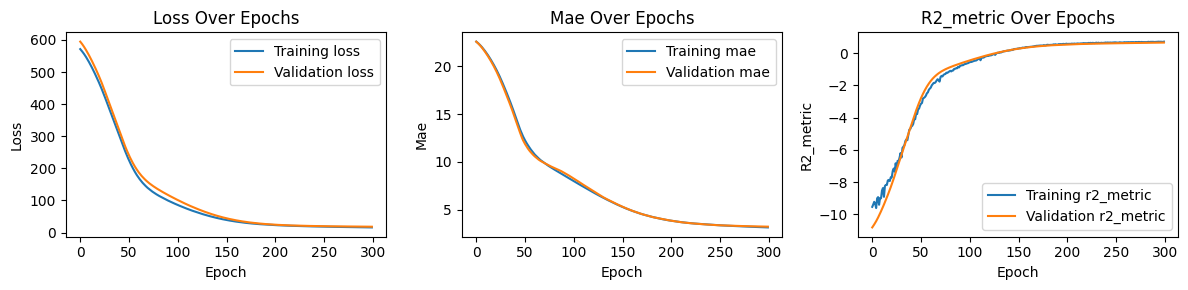

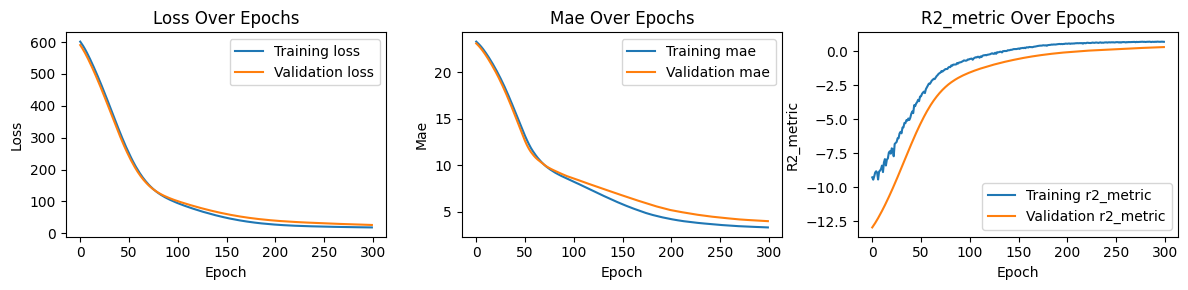

Final Metrics (Mean ± Std):
. loss: 25.7855 ± 10.9141
. mae: 3.9572 ± 0.9177
. r2_metric: 0.5626 ± 0.1732
. val_loss: 24.7026 ± 6.1258
. val_mae: 3.9563 ± 0.5639
. val_r2_metric: 0.4832 ± 0.1453
Training fold number 0.
Training fold number 1.
Training fold number 2.
Training fold number 3.
Training fold number 4.


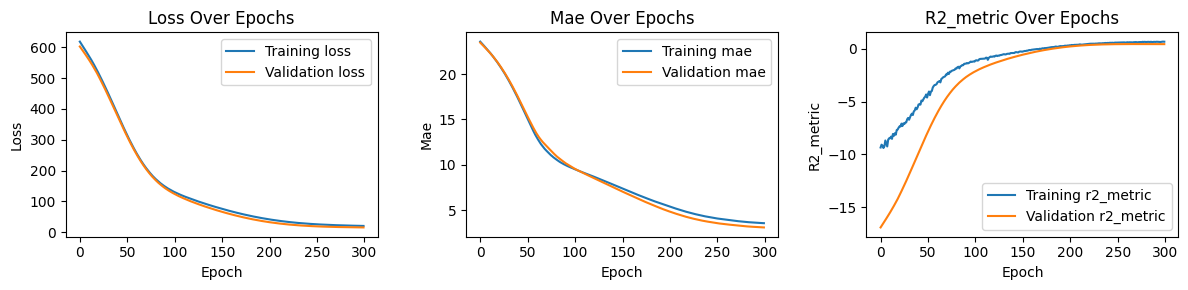

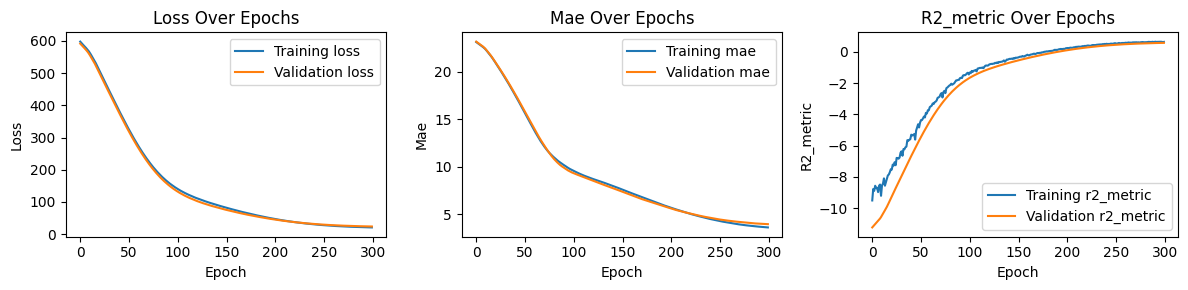

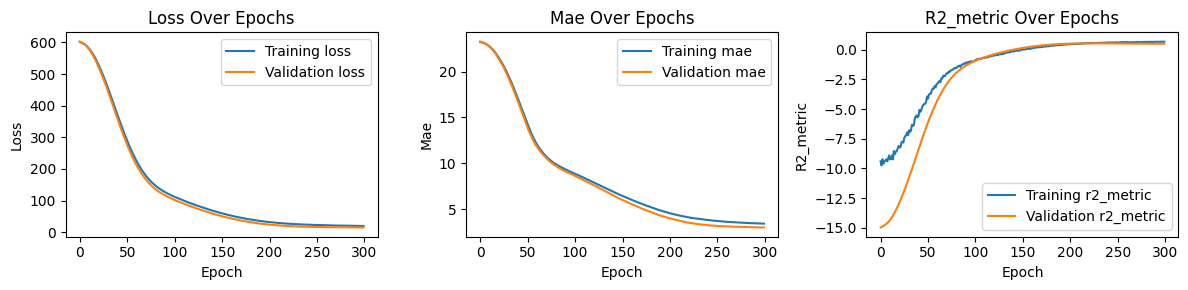

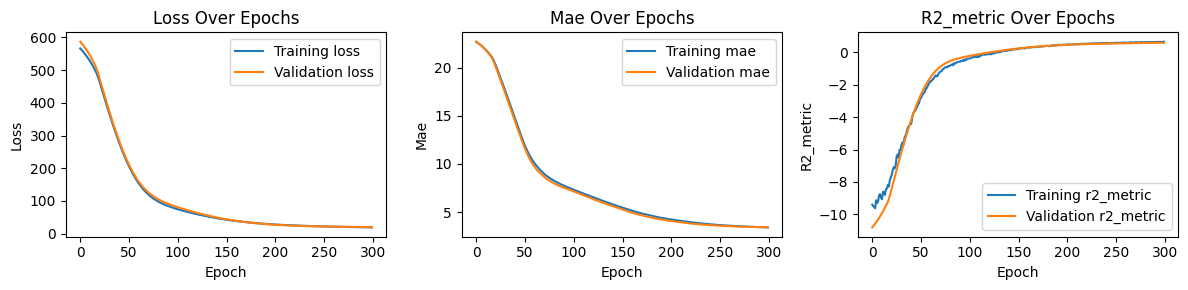

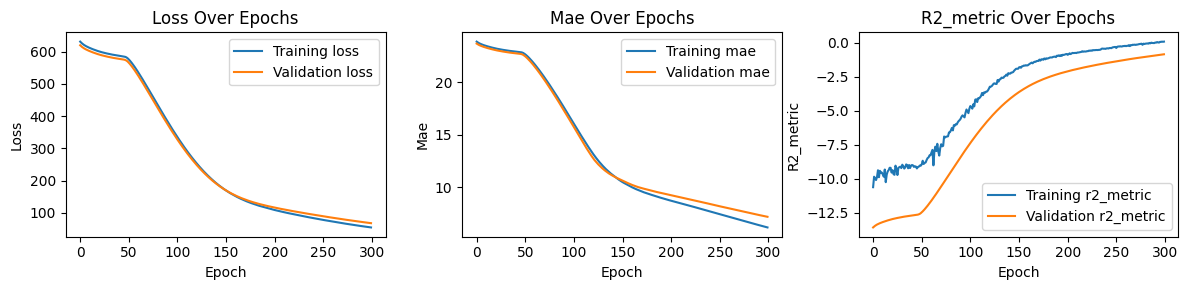

Final Metrics (Mean ± Std):
. loss: 26.9822 ± 13.8899
. mae: 4.0273 ± 1.0681
. r2_metric: 0.5422 ± 0.2286
. val_loss: 28.5697 ± 19.9541
. val_mae: 4.1269 ± 1.5585
. val_r2_metric: 0.2508 ± 0.5518
Training fold number 0.
Training fold number 1.
Training fold number 2.
Training fold number 3.
Training fold number 4.


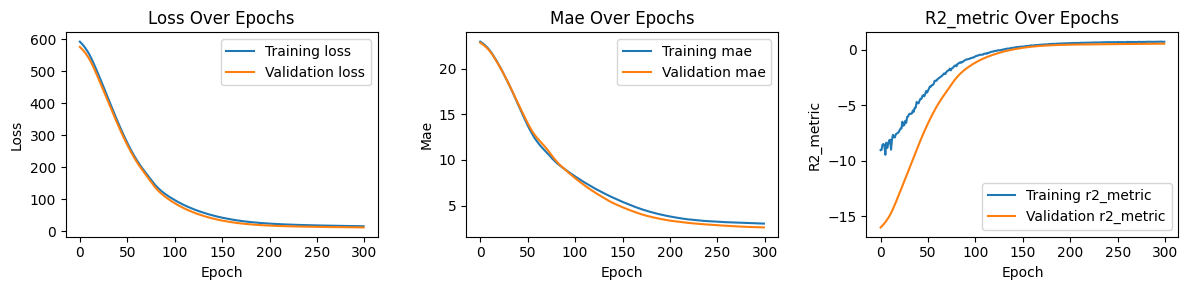

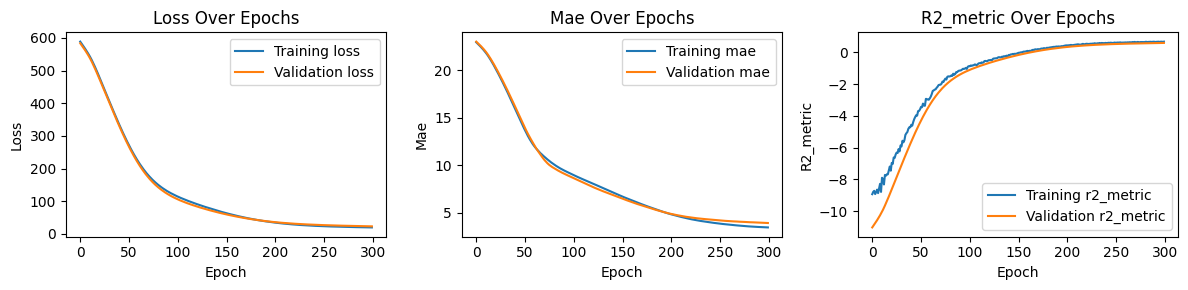

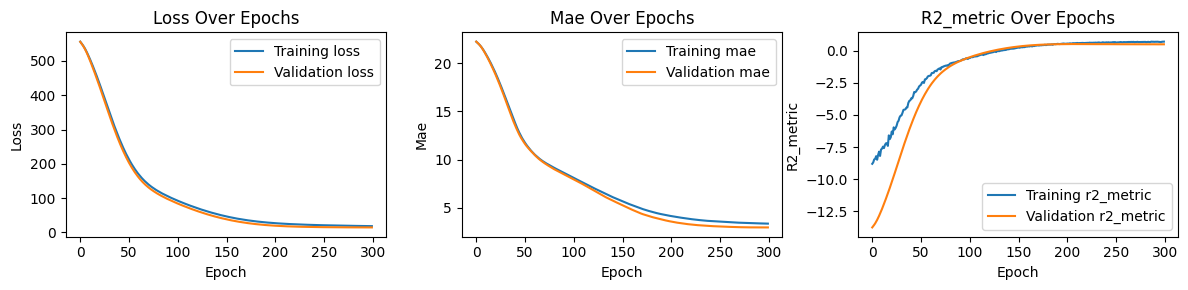

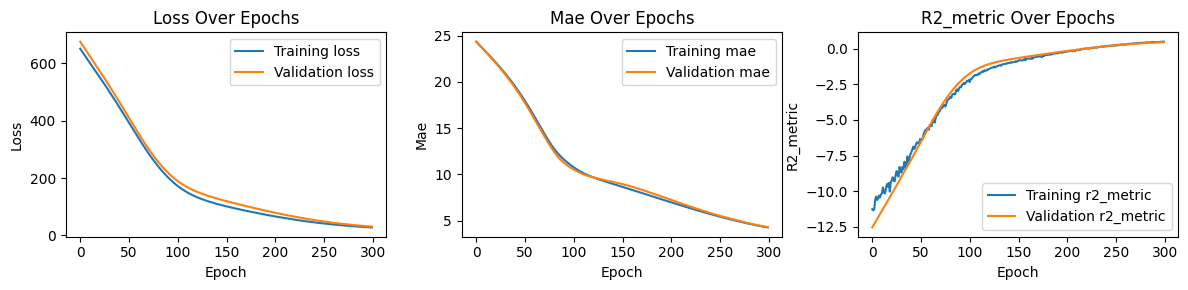

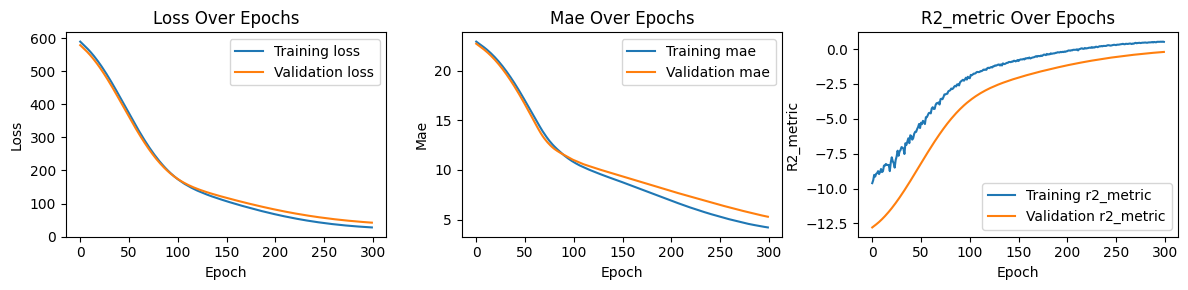

Final Metrics (Mean ± Std):
. loss: 21.9067 ± 4.8563
. mae: 3.6612 ± 0.4944
. r2_metric: 0.6221 ± 0.0979
. val_loss: 24.5502 ± 10.9624
. val_mae: 3.8132 ± 0.9586
. val_r2_metric: 0.3775 ± 0.2946
Training fold number 0.
Training fold number 1.
Training fold number 2.
Training fold number 3.
Training fold number 4.


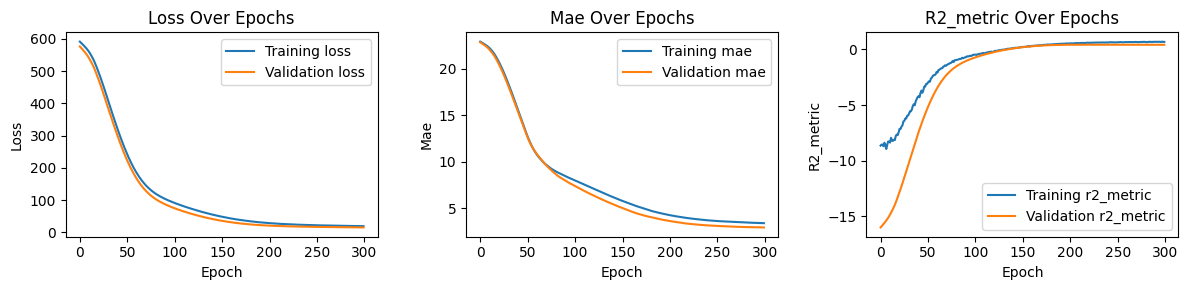

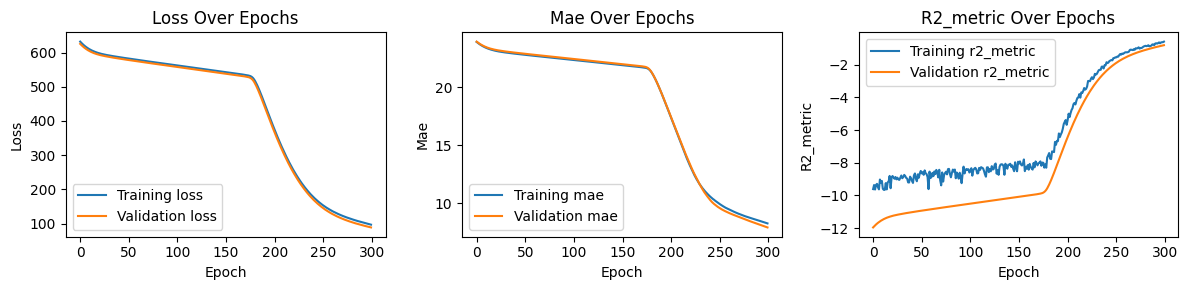

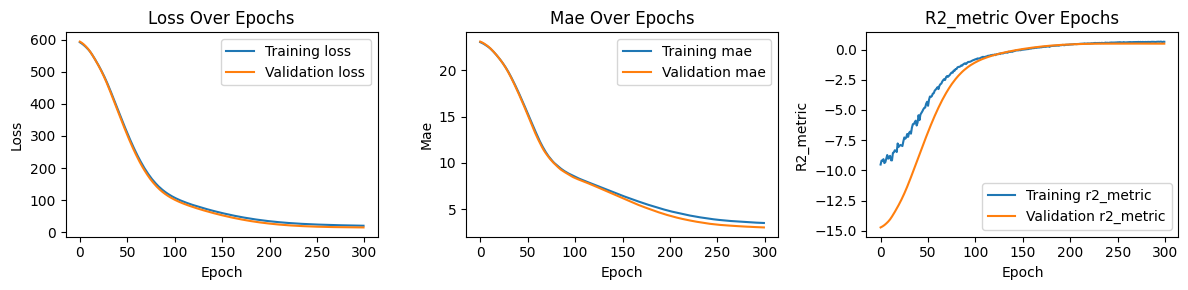

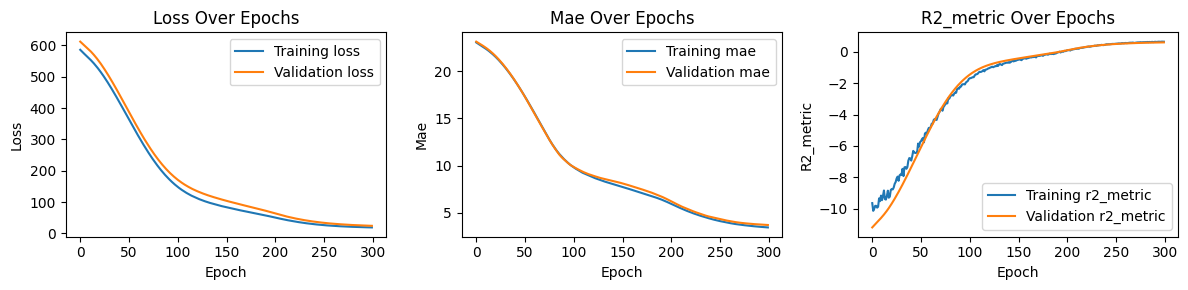

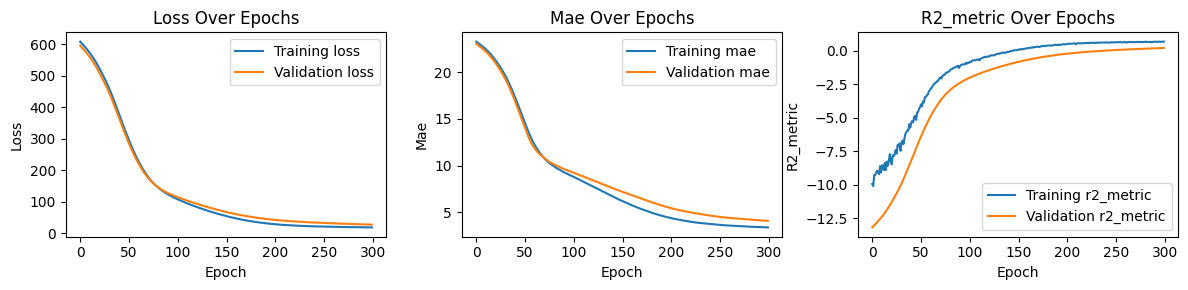

Final Metrics (Mean ± Std):
. loss: 34.8595 ± 30.9778
. mae: 4.4080 ± 1.9345
. r2_metric: 0.4121 ± 0.4971
. val_loss: 34.1890 ± 27.7166
. val_mae: 4.3433 ± 1.8411
. val_r2_metric: 0.1823 ± 0.5073
Training fold number 0.
Training fold number 1.
Training fold number 2.
Training fold number 3.
Training fold number 4.


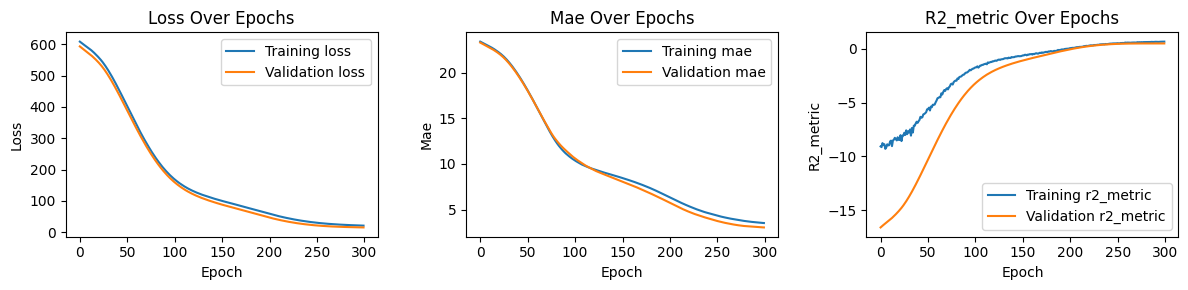

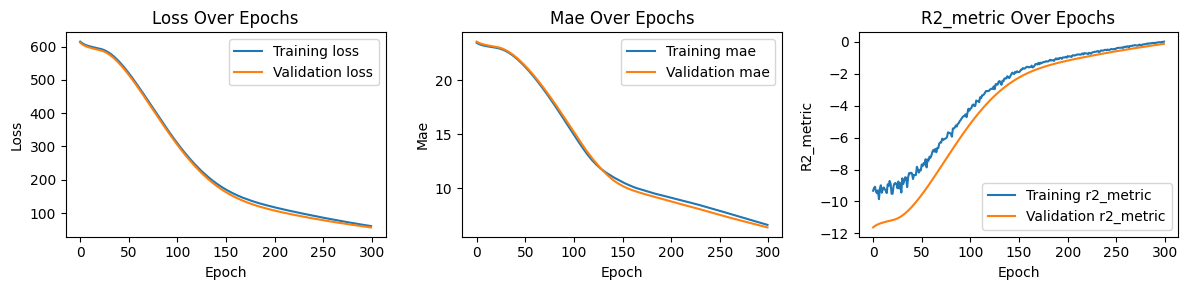

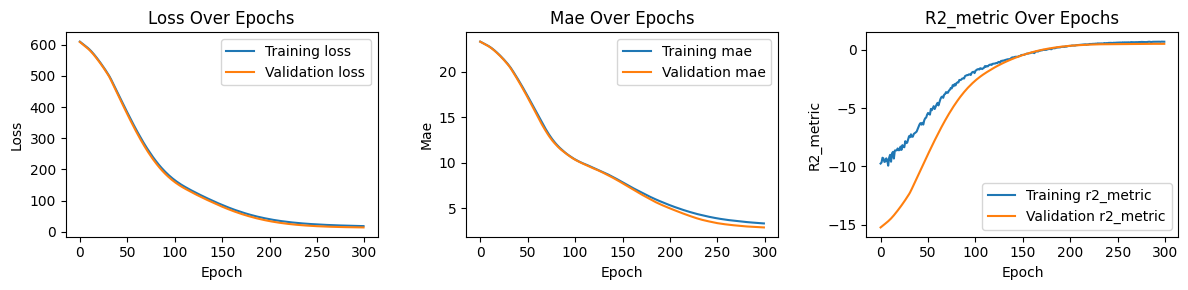

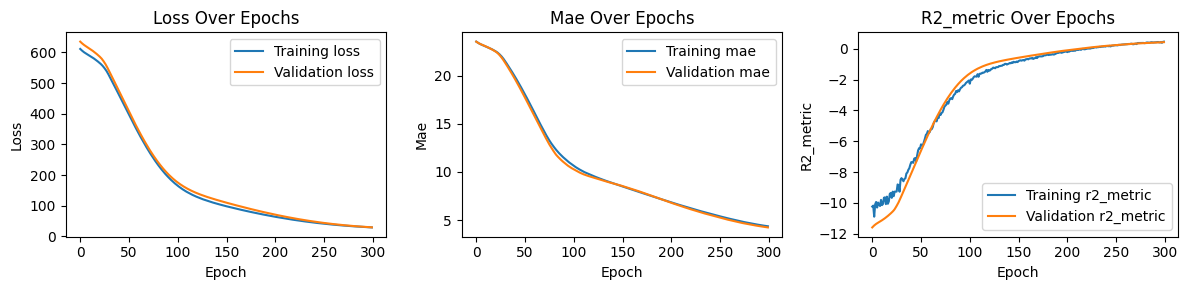

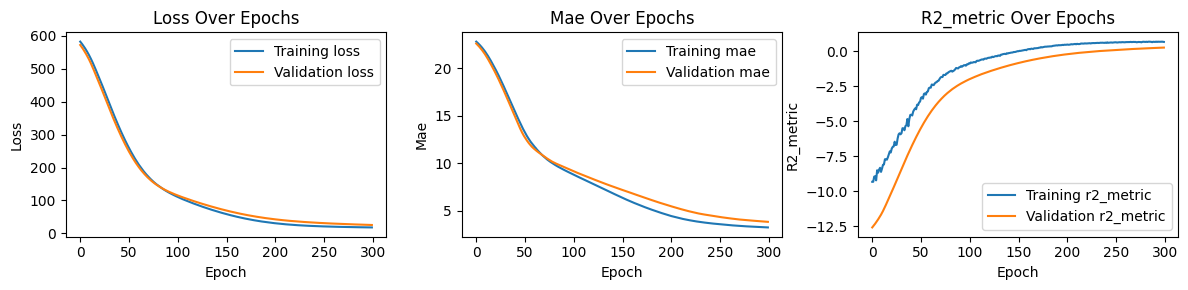

Final Metrics (Mean ± Std):
. loss: 29.4868 ± 16.2343
. mae: 4.2173 ± 1.2532
. r2_metric: 0.4977 ± 0.2605
. val_loss: 28.2209 ± 15.5370
. val_mae: 4.0784 ± 1.2454
. val_r2_metric: 0.3114 ± 0.2414


In [157]:
for neurons in neurons_choices:
    models, models_hist, final_metrics = train_kfold(dataset, neurons=neurons, epochs=300)

    for history in models_hist:
        history_dict = models_hist[history].history
        plot_metrics(history_dict)
    
    print("Final Metrics (Mean ± Std):")    
    for metric, values in final_metrics.items():
        mean = np.mean(values)
        std = np.std(values)
        print(f". {metric}: {mean:.4f} ± {std:.4f}")

## Test data

In [158]:
def find_best_score(metric='val_loss', evaluation='min'):
    # Find the best score and its index
    if evaluation=='min':
        best_score = min(final_metrics[metric])
    if evaluation=='max':
        best_score = max(final_metrics[metric])
    
    best_score_idx = final_metrics[metric].index(best_score)

    # Retrieve the best model
    best_model = models[best_score_idx]
    
    print(f"Best {metric}: {best_score:.4f}, achieved by fold {best_score_idx}.")

    return best_model

In [159]:
find_best_score('loss')
find_best_score('val_loss')
find_best_score('mae')
find_best_score('val_mae')
find_best_score('r2_metric', evaluation='max')
find_best_score('val_r2_metric', evaluation='max')

Best loss: 18.1325, achieved by fold 2.
Best val_loss: 13.9010, achieved by fold 2.
Best mae: 3.2638, achieved by fold 4.
Best val_mae: 2.8824, achieved by fold 2.
Best r2_metric: 0.6795, achieved by fold 2.
Best val_r2_metric: 0.4984, achieved by fold 2.


In [174]:
best_model = find_best_score('val_loss')

Best val_loss: 13.9010, achieved by fold 2.


Metrics for model_0:


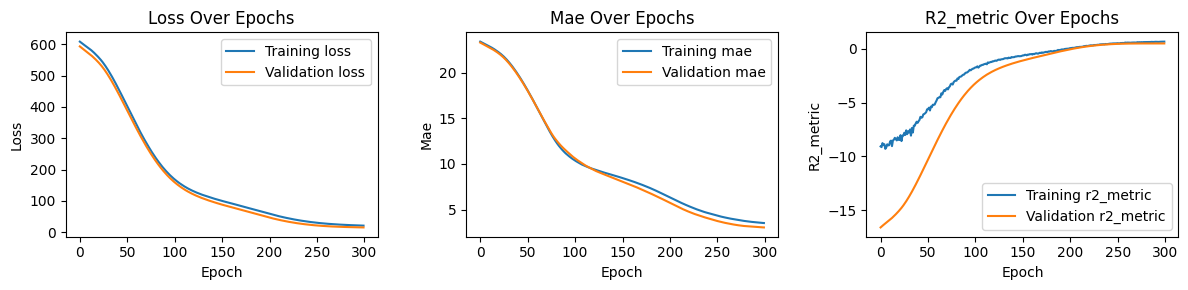

Metrics for model_1:


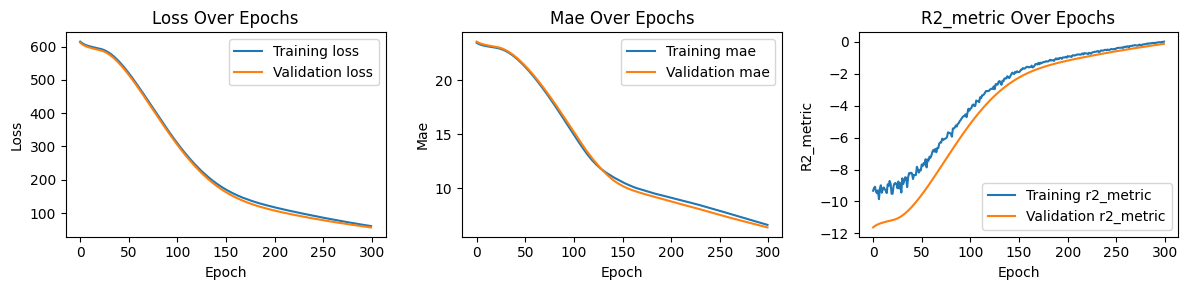

Metrics for model_2:


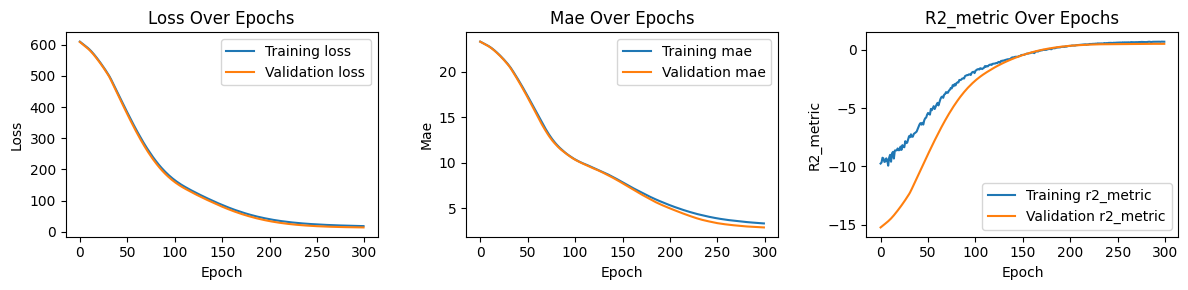

Metrics for model_3:


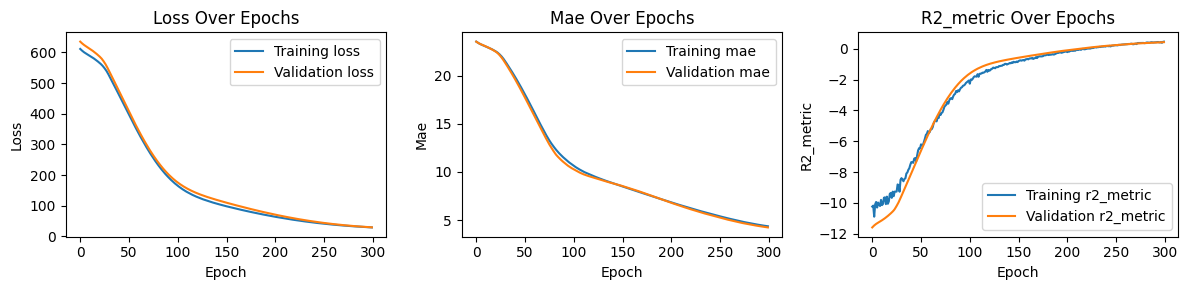

Metrics for model_4:


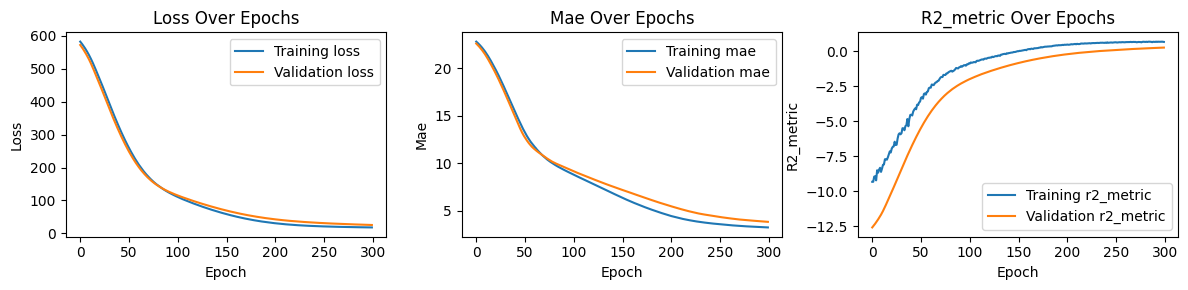

In [175]:
for fold, history in models_hist.items():
    history_dict = history.history  # Access history
    print(f"Metrics for {fold}:")
    plot_metrics(history_dict)

In [176]:
test_predictions = best_model.predict(X_test)
compare_results_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': test_predictions.flatten()
})
compare_results_df

2/2 [==============================] - 0s 1ms/step


,Actual,Predicted
0,25.0,23.041887
1,24.0,21.531492
2,23.0,17.175714
3,30.0,26.024588
4,27.0,25.736242
5,23.0,28.926863
6,15.0,14.399279
7,14.0,15.628716
8,18.0,17.877764
9,11.0,15.491105


In [177]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

r2_test = r2_score(compare_results_df['Actual'], compare_results_df['Predicted'])
mse_test = mean_squared_error(compare_results_df['Actual'], compare_results_df['Predicted'])
mae_test = mean_absolute_error(compare_results_df['Actual'], compare_results_df['Predicted'])

print("Metrics results on test data:")
print(f"R² Score:            {r2_test:.4f}")
print(f"Mean Squared Error:  {mse_test:.4f}")
print(f"Mean Absolute Error: {mae_test:.4f}")

Metrics results on test data:
R² Score:            0.7261
Mean Squared Error:  14.5687
Mean Absolute Error: 2.9537
